In [1]:
import numpy as np
import pandas as pd
import csv
import argparse
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns   
sns.set(context = "poster", font_scale = 0.95, rc={"lines.linewidth": 1.5, 'lines.markersize': 10, 'legend.frameon': True})

In [2]:
PLOT_DIR = "./Plots/"

In [3]:
ALEX_NET_LOG = "./logALEX.txt"
VGG_NET_LOG = "./logVGG.txt"

In [4]:
# Hard Coded #
def getAlexNetSpecification():
    # (input channels, output channels, kernel size, stride, padding)
    kernel_specifications = [(3, 64, 11, 4, 2), (64, 192, 5, 1, 2), (192, 384, 3, 1, 1), (384, 256, 3, 1, 1), (256, 256, 3, 1, 1)]
    output_specifications = [(1, 64, 63, 63), (1, 192, 31, 31), (1, 384, 15, 15), (1, 256, 15, 15), (1, 256, 15, 15)]
    return kernel_specifications, output_specifications

def getVGGSpecification():
    kernel_specifications = [(3, 64, 3, 1, 1), (64, 64, 3, 1, 1), (64, 128, 3, 1, 1), (128, 128, 3, 1, 1), (128, 256, 3, 1, 1), (256, 256, 3, 1, 1), (256, 256, 3, 1, 1), (256, 256, 3, 1, 1), (256, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1), (512, 512, 3, 1, 1)]
    output_specifications = [(1, 64, 256, 256), (1, 64, 256, 256), (1, 128, 128, 128), (1, 128, 128, 128), (1, 256, 64, 64), (1, 256, 64, 64), (1, 256, 64, 64), (1, 256, 64, 64), (1, 512, 32, 32), (1, 512, 32, 32), (1, 512, 32, 32), (1, 512, 32, 32), (1, 512, 16, 16), (1, 512, 16, 16), (1, 512, 16, 16), (1, 512, 16, 16)]
    return kernel_specifications, output_specifications

def getLayerParams(filter_spec, input_dimensions):
    number_of_Paremeters = filter_spec[0]*filter_spec[1]*(filter_spec[2]**2)
    number_of_InputValues = 1
    for d in input_dimensions:
        number_of_InputValues *= d
    return number_of_Paremeters, number_of_InputValues;


In [5]:
def loadAlexLog():
    input_spec = [(1,3,256,256)]
    kernel_spec, output_spec = getAlexNetSpecification()
    input_spec.extend(output_spec[:-1])
        
    layer_specification_dict = {}
        
    alex_header = ["ALGO", "BATCHSIZE", "TIME_TYPE" ]
    for i,k in enumerate(kernel_spec):
        header_ = "CONV"+str(i)
        
        layer_specification_dict[header_] = {}
        layer_specification_dict[header_]['input'] = input_spec[i]
        layer_specification_dict[header_]['filter'] = k
        layer_specification_dict[header_]['output'] = output_spec[i]

        alex_header.append(header_)
    
    data = pd.read_csv(ALEX_NET_LOG, header=None, names = alex_header) 
    return alex_header, data, layer_specification_dict

def loadVGGLog():
    input_spec = [(1,3,256,256)]
    kernel_spec, output_spec = getVGGSpecification()
    input_spec.extend(output_spec[:-1])
        
    layer_specification_dict = {}
        
    vgg_header = ["ALGO", "BATCHSIZE", "TIME_TYPE" ]
    for i,k in enumerate(kernel_spec):
        header_ = "CONV"+str(i)
        
        layer_specification_dict[header_] = {}
        layer_specification_dict[header_]['input'] = input_spec[i]
        layer_specification_dict[header_]['filter'] = k
        layer_specification_dict[header_]['output'] = output_spec[i]

        vgg_header.append(header_)
    
    data = pd.read_csv(VGG_NET_LOG, header=None, names = vgg_header) 
    return vgg_header, data, layer_specification_dict

## Layer Wise Analysis

In [25]:
def plotLayerWiseDataForTimeType(data, layer_cols, layer_specification_dict, batch_size, architecture, plot_path, time_type = ' CONV', label_y = 'Convolution Time (in ms)', plot_title = 'Convolution Time across Layers'):
    data_batch = data.loc[data['BATCHSIZE'] == batch_size].copy()
    data_frame_tt = data_batch.loc[data_batch['TIME_TYPE'] == time_type].copy()
    data__frame_tt_transposed = data_frame_tt.set_index('ALGO')[layer_cols].T
    data__frame_tt_transposed['Layers'] = data__frame_tt_transposed.index
    df_to_plot = data__frame_tt_transposed.melt('Layers', value_name='Time')
    
    X_ = []
    for i,row in df_to_plot.iterrows():
        num_filter_parameters, num_input_values = getLayerParams(layer_specification_dict[row['Layers']]['filter'],layer_specification_dict[row['Layers']]['input'])
        label =  row['Layers'] + "\n" + str(layer_specification_dict[row['Layers']]['filter']) + "\n" + "#P = " +str(num_filter_parameters) + "\n" + "IS = " + str(num_input_values) + "x" +str(batch_size)+"\n"
        X_.append(label)

    df_to_plot['X_LABELS'] = X_
    
    plt.figure(figsize=(max(16, len(layer_cols)*2+4),8)) # this creates a figure 8 inch wide, 4 inch high
    
    ax = sns.lineplot(x='X_LABELS', y='Time', hue='ALGO', marker = 'o', data=df_to_plot, sort=False)
    ax.set_yscale("log")
    ax.set(xlabel='Convolution Layers', ylabel = label_y)
    ax.tick_params(axis="x", labelsize = 13)
    ax.set_title(plot_title + " for Batchsize = " + str(batch_size), y=1.15)
    box = ax.get_position()
    
    ax.set_position([box.x0, box.y0, box.width , box.height * 0.95]) # resize position
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:],bbox_to_anchor=(0.5, 1.1), loc='upper center' , borderaxespad=0., ncol = len(layer_cols)-1)
    
    for i,row in df_to_plot.iterrows():
        x = row['X_LABELS']
        y = row['Time']
        ax.text(x,y,f'{y:.2f}\n',ha = 'center', va = 'center', clip_on=True, fontsize = 18)
    plt.savefig(plot_path+"LayerWise_"+architecture+time_type.strip()+'_'+str(batch_size)+'.png', bbox_inches='tight')
    plt.close()

In [26]:
def LayerWiseAnalysis(data, header, layer_specification_dict, architecture):
    layer_cols = header[3:]
    
    plot_dir_path = PLOT_DIR + architecture + "/"
    if(os.path.isdir(plot_dir_path)):
        shutil.rmtree(plot_dir_path)
    os.mkdir(plot_dir_path)
    
    time_types = [' CONV', ' OVERHEAD', ' TOTAL']
    y_labels = ['Convolution Time (in ms)', 'Overhead Time (in ms)', 'Total Time (in ms)']
    plot_titles = ['Convolution Time across Layers', 'Overhead Time across Layers', 'Total Time across Layers [ Includes the extra overheads ] ']
    for i,t in enumerate(time_types):
        plotLayerWiseDataForTimeType(data, layer_cols, layer_specification_dict, batch_size = 1, architecture = architecture, plot_path = plot_dir_path, time_type = t, label_y = y_labels[i], plot_title = plot_titles[i])
        plotLayerWiseDataForTimeType(data, layer_cols, layer_specification_dict, batch_size = 8, architecture = architecture, plot_path = plot_dir_path, time_type = t, label_y = y_labels[i], plot_title = plot_titles[i])

In [45]:
header, data, layer_specification_dict = loadVGGLog()
# LayerWiseAnalysis(data, header, layer_specification_dict, "VGG")

In [28]:
header, data, layer_specification_dict = loadAlexLog()
LayerWiseAnalysis(data, header, layer_specification_dict, "ALEX")

## Batchwise Analysis

In [46]:
timeType = ' CONV'
data_batchwise = data.loc[data['TIME_TYPE'] == timeType].copy()
layer_cols = header[3:]
data_batchwise['SUM'] = data_batchwise[layer_cols].sum(axis = 1)
data_batchwise

,ALGO,BATCHSIZE,TIME_TYPE,CONV0,CONV1,CONV2,CONV3,CONV4,CONV5,CONV6,CONV7,CONV8,CONV9,CONV10,CONV11,CONV12,CONV13,CONV14,CONV15,SUM
1,DIRECT,1,CONV,75.694600,1121.62000,486.63000,971.77000,486.11600,1101.17000,1101.27000,1101.34000,549.78200,1102.35000,1102.35000,1102.59000,273.50800,273.53100,273.52200,273.50700,11396.750600
4,DIRECT,2,CONV,97.347200,1949.30000,974.59400,1946.39000,977.02400,2005.03000,2005.19000,2005.46000,1001.91000,2145.84000,2146.20000,2146.27000,560.46900,560.51500,560.71400,560.65000,21642.903200
7,DIRECT,4,CONV,195.063000,3910.17000,1954.00000,3903.81000,1976.36000,3986.48000,3987.75000,3988.89000,1994.00000,4276.39000,4277.19000,4277.79000,1018.79000,1018.82000,1018.77000,1018.79000,42803.063000
10,DIRECT,8,CONV,391.626000,7847.74000,3923.07000,7849.39000,3970.57000,7951.03000,7951.12000,7952.45000,3973.50000,8533.63000,8534.70000,8535.24000,2062.33000,2062.34000,2062.41000,2062.50000,85663.646000
13,IM2COL,1,CONV,0.529824,5.96637,1.98422,3.90906,2.08141,4.00947,3.23622,4.00800,1.64240,3.06208,3.07149,3.05654,1.33174,1.32762,1.34019,1.30554,41.862174
16,IM2COL,2,CONV,0.853600,9.65005,3.25610,6.27328,2.79971,5.40266,4.78003,5.32352,2.47235,4.14637,4.13213,4.13459,1.79088,1.76867,1.76298,1.76896,60.315880
19,IM2COL,4,CONV,1.348260,15.31340,5.15910,9.95370,4.61658,9.45110,9.46864,10.06470,4.26314,8.31616,8.30518,8.32896,3.58086,3.55030,3.57469,3.55235,108.847120
22,IM2COL,8,CONV,2.693500,30.67160,10.27590,19.70260,9.80272,18.98730,19.49490,20.45600,8.52198,16.68580,16.64100,16.63930,7.20394,7.21978,7.11104,7.11334,219.220700
25,FFT,1,CONV,249.754000,364.73200,158.97100,324.35500,102.07400,208.59000,208.81100,208.87400,146.69900,311.98300,311.79400,311.87600,57.97220,57.75610,57.78510,57.81320,3139.839600
28,FFT,2,CONV,30.529700,562.85500,246.25700,499.70600,160.20800,326.97300,328.56700,328.39500,227.76500,486.23500,487.24400,485.71300,91.26370,91.84220,91.95900,92.48570,4537.998300


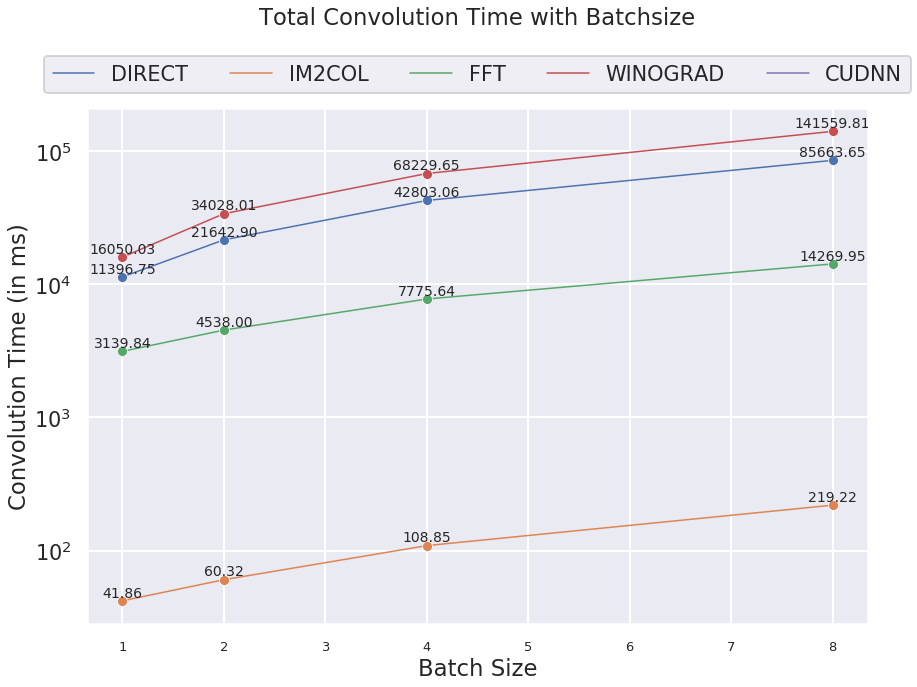

In [49]:
plt.figure(figsize=(14,10)) # this creates a figure 8 inch wide, 4 inch high

ax = sns.lineplot(x='BATCHSIZE', y='SUM', hue='ALGO', marker = 'o', data=data_batchwise, sort=False)
ax.set_yscale("log")
ax.set(xlabel='Batch Size', ylabel = "Convolution Time (in ms)")
ax.tick_params(axis="x", labelsize = 13)
ax.set_title("Total Convolution Time with Batchsize", y=1.15)
box = ax.get_position()

ax.set_position([box.x0, box.y0, box.width , box.height * 0.95]) # resize position

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:],bbox_to_anchor=(0.5, 1.1), loc='upper center' , borderaxespad=0., ncol = len(layer_cols)-1)

for i,row in data_batchwise.iterrows():
    x = row['BATCHSIZE']
    y = row['SUM']
    ax.text(x,y,f'{y:.2f}\n',ha = 'center', va = 'center', clip_on=True, fontsize = 14)
# plt.savefig(plot_path+"LayerWise_"+architecture+time_type.strip()+'_'+str(batch_size)+'.png', bbox_inches='tight')
plt.show()